In [1]:
#https://www.youtube.com/watch?v=zxD-v3ve-bk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import splitfolders
import os

In [4]:
splitfolders.ratio('data', output="data_split", seed=42, ratio=(0.8, 0.1,0.1)) # default values

In [63]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(30)
                                ])

In [61]:
train_data = datasets.ImageFolder(root=os.path.join("data_split", "train"), transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

val_data = datasets.ImageFolder(root=os.path.join("data_split", "val"), transform=transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)

In [62]:
print(train_data)

Dataset ImageFolder
    Number of datapoints: 202
    Root location: data_split\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


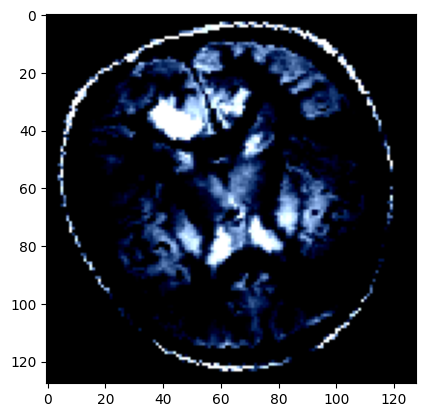

In [66]:
img, label = train_data[100]
plt.imshow(img.permute(1,2,0))

In [68]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.leaky_relu = nn.LeakyReLU()
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.pool1(self.leaky_relu(self.conv1(x)))
        x = self.pool2(self.leaky_relu(self.conv2(x)))
        x = self.pool3(self.leaky_relu(self.conv3(x)))
        x = self.pool4(self.leaky_relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
num_epochs = 50
model = CNNModel(num_classes=len(train_data.classes))
error = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [89]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)

    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = error(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / len(val_loader)
    val_loss_list.append(val_loss)
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)  

    scheduler.step(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/60], Train Loss: 0.0133, Val Loss: 0.5520, Accuracy: 91.67%
Epoch [2/60], Train Loss: 0.0061, Val Loss: 0.2241, Accuracy: 95.83%
Epoch [3/60], Train Loss: 0.0195, Val Loss: 0.1683, Accuracy: 95.83%
Epoch [4/60], Train Loss: 0.0138, Val Loss: 0.3294, Accuracy: 87.50%
Epoch [5/60], Train Loss: 0.0103, Val Loss: 0.3019, Accuracy: 87.50%
Epoch [6/60], Train Loss: 0.0072, Val Loss: 0.2068, Accuracy: 91.67%
Epoch [7/60], Train Loss: 0.0047, Val Loss: 0.2133, Accuracy: 87.50%
Epoch [8/60], Train Loss: 0.0055, Val Loss: 0.0356, Accuracy: 100.00%
Epoch [9/60], Train Loss: 0.0051, Val Loss: 0.0940, Accuracy: 91.67%
Epoch [10/60], Train Loss: 0.0040, Val Loss: 0.1636, Accuracy: 91.67%
Epoch [11/60], Train Loss: 0.0044, Val Loss: 0.4565, Accuracy: 91.67%
Epoch [12/60], Train Loss: 0.0171, Val Loss: 0.2107, Accuracy: 91.67%
Epoch [13/60], Train Loss: 0.0081, Val Loss: 0.1373, Accuracy: 91.67%
Epoch [14/60], Train Loss: 0.0055, Val Loss: 0.0962, Accuracy: 95.83%
Epoch [15/60], Train Loss: 0

In [97]:
# Testing the model on test data
test_data = datasets.ImageFolder(root=os.path.join("data_split", "test"), transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

model.eval()
test_running_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = error(outputs, labels)
        test_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss = test_running_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.1332, Test Accuracy: 92.59%
